In [3]:
from keras.models import Sequential #sequential model

In [3]:
import cv2

In [4]:
from keras.layers import Dropout,Conv2D,Flatten,Dense, MaxPooling2D, BatchNormalization

In [5]:
from keras.preprocessing import image

In [6]:
from keras.utils.np_utils import to_categorical

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
import numpy as np

## data generation

In [9]:
train_path = "Drowsiness detection/images/training_images"  #path of images for training
valid_path = "Drowsiness detection/images/validation_images"  #path of images for validation
test_path = "Drowsiness detection/images/test_images" #path of images for testing

In [42]:
#ImageDataGenerator is used for generating data
#flow_from_directory() generates batches of normalized tensor image data from the respective data directories.
#we provide path for directory in flow_from_directory() function
#target_size is size of the image and we use gray scale because many operations perform better in grayscale images
#class_mode will devide images into two class (open,closed)
#shuffle will shuffle the data everytime
#batch_size is number of batches we want to make from directory images
train_batches = image.ImageDataGenerator().flow_from_directory(directory=train_path, target_size=(24,24),
    class_mode='categorical',shuffle=True, batch_size=10, color_mode='grayscale')
valid_batches = image.ImageDataGenerator().flow_from_directory(directory=valid_path, target_size=(24,24),
    class_mode='categorical',shuffle=True, batch_size=2, color_mode='grayscale')
test_batches = image.ImageDataGenerator().flow_from_directory(directory=test_path, target_size=(24,24),
    class_mode='categorical',shuffle=True, batch_size=10, color_mode='grayscale')
#we have 300 images in training_images , 20 images in validation_images and 40 images in test_images 

Found 300 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [97]:
print(test_batches.class_indices) #it has assigned 0 index to closed and 1 to open for every directory
print(train_batches.class_indices)
print(valid_batches.class_indices)

{'closed': 0, 'open': 1}
{'closed': 0, 'open': 1}
{'closed': 0, 'open': 1}


In [60]:
test_label = []  #collecting labels for test images
count = 0
for i,j in test_batches:
    if count == 4:   #because we have total 40 images and 10 images per batch , so there will be 4 batch
        break        #if we will not break this , it will go into an infinite loop
    count+=1
    for k in j:
        test_label.append(k)  #appending labels to test_label

## data visualization

In [61]:
test_label = np.array(test_label) #defining numpy array for labels because faster and easier execution
print(test_label.shape)  #it contains array for all 40 images, [0,1] for open eye and [1,0] for closed eye 
print(type(test_label[0])) #test_label is a 2d numpy array
print(type(test_label))

(40, 2)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [45]:
for x,y in train_batches: #train_batches contains images and corresponding labels for that images
    print(x.shape) #x has 10 gray images (one batch) of size (24,24)
    print(y) #y contains label for one batch
    break #if we do not break , it will go into infinite loop

(10, 24, 24, 1)
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


[0. 1.]


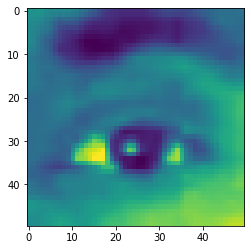

[1. 0.]


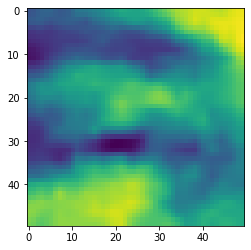

[1. 0.]


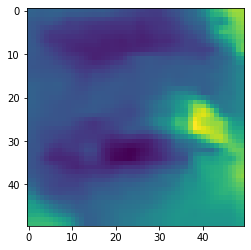

[1. 0.]


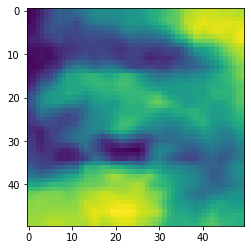

[1. 0.]


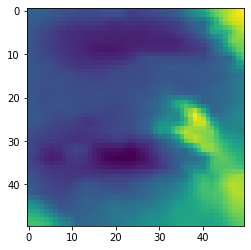

[0. 1.]


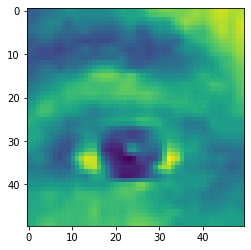

[1. 0.]


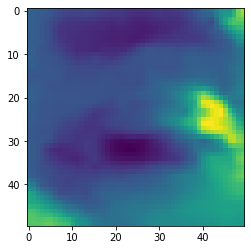

[0. 1.]


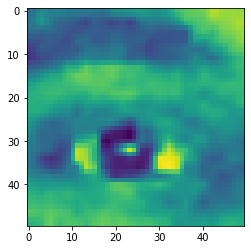

[1. 0.]


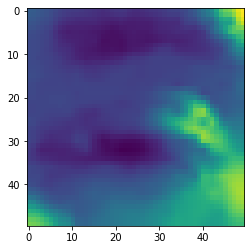

[1. 0.]


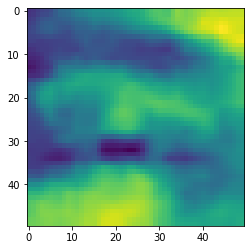

In [93]:
for imgs,labels in train_batches:
    for i in range(10):
        print(labels[i])
        img = cv2.resize(imgs[i],(50,50))  #resizing image for plotting
        plt.imshow(img) #plotting image
        plt.show()
    break

[0. 1.]


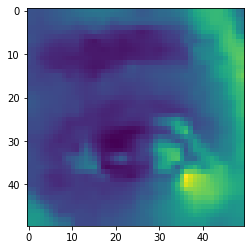

[0. 1.]


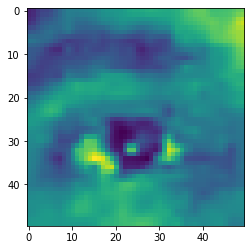

[1. 0.]


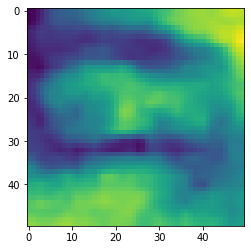

[1. 0.]


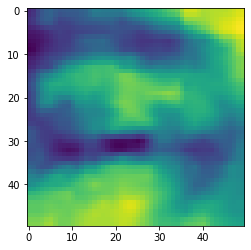

[0. 1.]


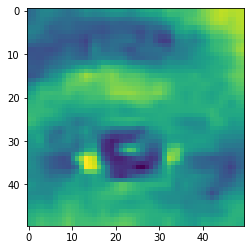

[1. 0.]


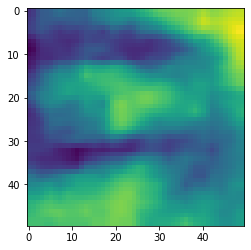

[0. 1.]


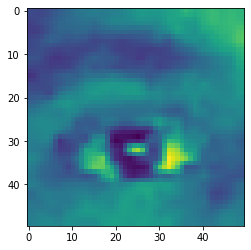

[1. 0.]


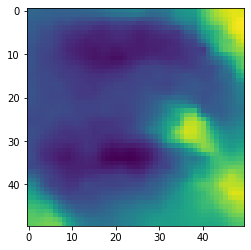

[1. 0.]


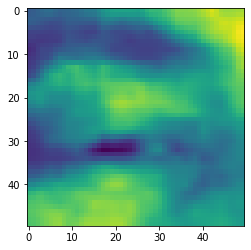

[1. 0.]


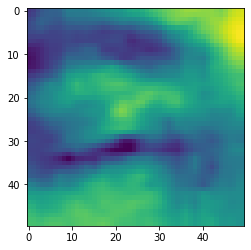

In [94]:
for imgs,labels in test_batches: #visualization of test images
    for i in range(10):
        print(labels[i])
        img = cv2.resize(imgs[i],(50,50))
        plt.imshow(img)
        plt.show()
    break

## Model Defination

In [7]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(24,24,1)),
    
    #a convolutional layer receives input,transforms the input in some way,and then outputs the transformed input to the next layer.
    #With each convolutional layer, we need to specify the number of filters the layer should have. These filters are actually
    #what detect the patterns like edges,objects,colors,shapes,curves etc.
    #In even deeper layers, the filters are able to detect even more sophisticated objects like full dogs, cats, birds.
    #A filter can technically just be thought of as a relatively small matrix ( tensor), for which, we decide the number of 
    #rows and columns this matrix has, and the values within this matrix are initialized with random numbers. 
    # we take the dot product of the filter with the first 3 x 3 block of pixels, and then that result is stored in the output channel.
    #Then, the filter slides to the next 3 x 3 block, computes the dot product, and stores the value as the next pixel in the output channel.
    
    #In an artificial neural network, an activation function is a function that maps a node's inputs to its corresponding output. 
    #as we know that every connection in network has some wights ,so we calculate the sum of products of input and weights and give
    #it to the activation function
    # relu(x) = max(0,X) so more positive the neuron is more activated it is
    
    MaxPooling2D(pool_size=(1,1)),
    #When added to a model, max pooling reduces the dimensionality of images by reducing the 
    #number of pixels in the output from the previous convolutional layer
    #The first parameter we’re specifying is the pool_size. This is the size of what we were calling a filter before, and in our example, we used a 1 x 1 filter. 
    
    Conv2D(32,(3,3),activation='relu'), #another 2-dimentional convolutional layer because we are working with 2d images
    #32 convolution filters used each of size 3x3

    MaxPooling2D(pool_size=(1,1)),
    
    Conv2D(64, (3, 3), activation='relu'),# third convolutional layer
    #64 convolution filters used each of size 3x3
    
    MaxPooling2D(pool_size=(1,1)),
    #choose the best features via pooling
    
    #randomly turn neurons on and off to improve convergence
    Dropout(0.25),
    #flatten since too many dimensions, we only want a classification output
    Flatten(),
    #fully connected to get all relevant data
    Dense(128, activation='relu'),
    #one more dropout for convergence' sake 
    Dropout(0.5),
    #output a softmax to squash the matrix into output probabilities
    Dense(2, activation='softmax')
    #we have two output nodes which denotes either open or closed
])

In [49]:
model.summary() #summary of our model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 22, 22, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 20, 20, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 18, 18, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 18, 18, 64)       

## training our model

In [8]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#The Adam optimization algorithm is an extension to stochastic gradient descent
#loss function is for calculating loss

In [51]:
model.fit_generator(train_batches, validation_data=valid_batches,epochs=15,steps_per_epoch=30,validation_steps=10,verbose=2)
#our model will train on train_batches and will validate on valid_batches 
#we have make 15 epochs ,you can give any number
#verbose is 2, which just specifies the verbosity of the log output printed to the console during training. 
#we have 300 training images and 10 per batch so steps_per_epoch is 30
#we have 20 validation images and 2 per batch so validation_steps is 10

Epoch 1/15
 - 2s - loss: 16.5815 - accuracy: 0.5875 - val_loss: 4.3987e-05 - val_accuracy: 0.5000
Epoch 2/15
 - 1s - loss: 0.2008 - accuracy: 0.9438 - val_loss: 4.1723e-07 - val_accuracy: 1.0000
Epoch 3/15
 - 1s - loss: 0.0314 - accuracy: 0.9875 - val_loss: 4.7684e-07 - val_accuracy: 1.0000
Epoch 4/15
 - 1s - loss: 0.0398 - accuracy: 0.9812 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 5/15
 - 1s - loss: 0.0397 - accuracy: 0.9937 - val_loss: 6.4969e-04 - val_accuracy: 1.0000
Epoch 6/15
 - 1s - loss: 0.0173 - accuracy: 1.0000 - val_loss: 0.0050 - val_accuracy: 1.0000
Epoch 7/15
 - 1s - loss: 0.0134 - accuracy: 0.9937 - val_loss: 2.0802e-05 - val_accuracy: 1.0000
Epoch 8/15
 - 1s - loss: 0.0051 - accuracy: 1.0000 - val_loss: 6.7885e-05 - val_accuracy: 1.0000
Epoch 9/15
 - 1s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 10/15
 - 1s - loss: 4.5906e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 11/15
 - 1s - loss: 5.2386

In [52]:
model.save('Drowsiness detection/models/myModel.h5', overwrite=True)#saving our model

In [83]:
predictions = model.predict_generator(generator=test_batches, steps=4, verbose=0)#making prediction about test_batches

## testing our model

In [62]:
from sklearn.metrics import confusion_matrix #for plotting confusion matrix

In [81]:
import itertools

In [84]:
print(predictions.shape) #prediction contain probability of classes for every image
print(type(predictions)) #it is a numpy array
print(type(predictions[0])) #it contains numpy array of probabilites of each class
print(predictions[0]) #first element is probability that image is from class closed and second is probability for open class
for i in predictions:
    i[0]=round(i[0]) #rounding the probabilities to convert them into 0 and 1
    i[1]=round(i[1])
print(predictions[0])

(40, 2)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[1.0000000e+00 7.3845423e-09]
[1. 0.]


In [85]:
cm = confusion_matrix(y_true=test_label[:,0], y_pred=predictions[:,0]) #making confusion matrix object

In [79]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    #This function prints and plots the confusion matrix.
    #Normalization can be applied by setting `normalize=True`.
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[10  9]
 [10 11]]


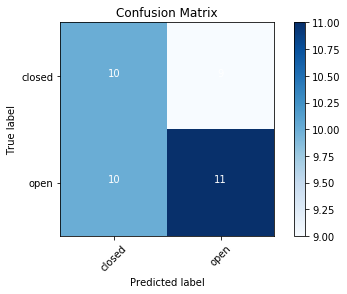

In [95]:
cm_plot_labels = ['closed','open']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix') #plotting confusion matrix

as we can see our model is not predicting well<br>
it has predicted 10 open eyes as closed eyes and 9 closed eyes as open eyes<br>
the reason can be the size of our dataset which is very small and all the images are taken in same intensity of light<br>
if images are taken in large amount and in different intesities it can predict well.